In [0]:
// libraryDependencies += "com.lihaoyi" %% "pprint" % "0.5.6"

In [1]:
import $ivy.`org.scalanlp::breeze:1.0`
import breeze.linalg._
import breeze.numerics._
import breeze.stats.DescriptiveStats._
import breeze.stats.regression.{leastSquares, lasso}

import $ivy.`org.plotly-scala::plotly-almond:0.7.6`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._
repl.pprinter() = repl.pprinter().copy(defaultHeight = 3)

import $ivy.$                         

import breeze.linalg._

import breeze.numerics._

import breeze.stats.DescriptiveStats._

import breeze.stats.regression.{leastSquares, lasso}


import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


#### Load Dataset

In [2]:
import sys.process._
import scala.io.Source

import sys.process._

import scala.io.Source

In [3]:
"ls -ll" !

total 9632
-rw-rw-r-- 1 jovyan  1000    2408 Aug 14 19:25 about
-rw-r--r-- 1 jovyan users 2997727 Aug 23 14:43 Dataset.csv
-rw-r--r-- 1 jovyan users   45816 Aug 25 16:24 grad_desc_mse_linreg_ridge.png
-rw-r--r-- 1 jovyan users 6810815 Aug 25 23:03 hw001_LinReg.ipynb


res2: Int = 0

In [4]:
"head -5 Dataset.csv" !

likes,Checkins,Returns,Category,commBase,comm24,comm48,comm24_1,diff2448,baseTime,length,shares,hrs,sun_pub,mon_pub,tue_pub,wed_pub,thu_pub,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,output
634995,0,463,1,0,0,0,0,0,65,166,2,24,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
634995,0,463,1,0,0,0,0,0,10,132,1,24,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
634995,0,463,1,0,0,0,0,0,14,133,2,24,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
634995,0,463,1,7,0,3,7,-3,62,131,1,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


res3: Int = 0

In [9]:
val head = Source.fromFile("Dataset.csv").getLines.take(1).toList(0).split(",").map(_.toLowerCase)

// val data = Source.fromFile("Dataset.csv").getLines.drop(1).toList.map(
//     _.split(",").map(x => if (x.length > 0) Some(x.toDouble) else None)
// ).par

val dataRow = Source.fromFile("Dataset.csv").getLines.drop(1).toList.map(
    _.split(",").map(x => if (x.length > 0) x.toDouble else NaN)
)
//.par

def ix (c: String): Int = head.indexOf(c)

val (ncol, nrow) = (head.length, data.length)


val dataCol = Array.ofDim[Double](ncol, nrow)
//.par

dataRow.zipWithIndex.map{ 
    case (row, i) => row.zipWithIndex.map{ 
        case (x, j) => dataCol(j)(i) = x
    } 
}
println(head.mkString("\n"))

likes
checkins
returns
category
commbase
comm24
comm48
comm24_1
diff2448
basetime
length
shares
hrs
sun_pub
mon_pub
tue_pub
wed_pub
thu_pub
fri_pub
sat_pub
sun_base
mon_base
tue_base
wed_base
thu_base
fri_base
sat_base
output


head: Array[String] = Array(
  "likes",
...
dataRow: List[Array[Double]] = List(
  Array(
...
defined function ix
ncol: Int = 28
nrow: Int = 40949
dataCol: Array[Array[Double]] = Array(
  Array(
...
res8_5: List[Array[Unit]] = List(
  Array(
...

In [10]:
dataCol

res9: Array[Array[Double]] = Array(
  Array(
...

#### Stats and Missing imputation

In [6]:

val means   = cols.map(
    x => x.filter(!_.isEmpty).map(_.get.toDouble)
).map(
    x => breeze.stats.mean(DenseVector(x))
).toArray

val medians = cols.map(
    x => x.filter(!_.isEmpty).map(_.get.toDouble)
).map(
    x => breeze.stats.median(DenseVector(x))
).toArray

val cols_filled = cols.zipWithIndex.map{
    case (v, i) => v.map( x => x.getOrElse(medians(i)))
}.toArray


means: Array[Double] = Array(
  1313813.7475396227,
...
medians: Array[Double] = Array(
  292911.0,
...
cols_filled: Array[Array[Double]] = Array(
  Array(
...

#### Generate simple data for tests

In [7]:
def test_data(k1:Double, k2:Double, k3:Double, c:Double, n:Int) = {
    val norm = breeze.stats.distributions.Gaussian(0, 1)
    val e    = DenseMatrix.rand(n, 1, norm)
    val x1   = DenseMatrix.rand(n, 1, norm)
    val x2   = DenseMatrix.rand(n, 1, norm)
    val x3   = DenseMatrix.rand(n, 1, norm)
    val ones = DenseMatrix.ones[Double](n, 1)
    val y = x1*k1 + x2*k2 + x3*k3 + c + e
    (DenseMatrix.horzcat(x1,x2,x3,ones), y.toDenseVector)    
}

defined function test_data

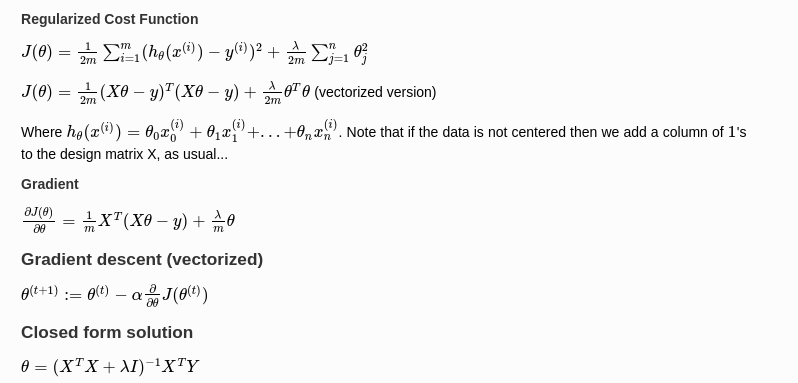

#### Gradient Descent - Ridge Regularized

In [8]:
def SimpleGradientDescent( 
    
    matrix: DenseMatrix[Double],  // feature--matrix
    y: DenseVector[Double],       // target vector
    iter: Int,                    // iteration number 
    alpha: Double,                // descent step
    L: Double                     // regularization
    
) : (DenseVector[Double], DenseVector[Double])  = {
    
    var w0 = DenseVector.rand(matrix.cols)
    var w =  w0
    var mse: Double = sum((y - (matrix * w)).map(x => scala.math.pow(x,2))) 
    var mse_hist = DenseVector.zeros[Double](iter)

    for (i <- 1 to iter) {
        val jacob = (1/matrix.rows.toDouble)*(matrix.t * (matrix * w0 - y)) + L*w0
        w = w0 - alpha*jacob
        w0 = w
        mse = sum((y - (matrix * w)).map(x => scala.math.pow(x,2)))
        mse_hist(i-1) = mse
    } 
    
    (w, mse_hist)
}


defined function SimpleGradientDescent

#### Sample with known dependency y ~ 10x1+20x2+30x3-10

In [9]:
val (tmat, ty) = test_data(10,20,30,-10,1000)

tmat: DenseMatrix[Double] = 0.17097212928301533     -1.3462499195319615    -0.7818341076976206   1.0  
0.6885785817869247      0.09809528703325063    0.19846991619684023   1.0  
...
ty: DenseVector[Double] = DenseVector(-59.831264954763625, 3.804386707318026, -57.891932836519416, -105.6142978205006, -17.890494742141744, 14.652666026931493, -49.88077288356792, -12.75...

#### Test Custom Vs Breeze Least 

In [10]:
val (w1, _) = SimpleGradientDescent(tmat, ty, 1000, 0.1, 0.001)
val test_model = leastSquares(tmat, ty)
val w2 = test_model.coefficients

Aug 25, 2020 11:00:28 PM com.github.fommil.netlib.BLAS <clinit>
Aug 25, 2020 11:00:28 PM com.github.fommil.netlib.BLAS <clinit>
Aug 25, 2020 11:00:28 PM com.github.fommil.netlib.LAPACK <clinit>
Aug 25, 2020 11:00:28 PM com.github.fommil.netlib.LAPACK <clinit>


w1: DenseVector[Double] = DenseVector(9.984584759731188, 20.025504450614676, 29.976691976954736, -9.982352314827157)
test_model: breeze.stats.regression.LeastSquaresRegressionResult = LeastSquaresRegressionResult(
  DenseVector(9.995993662010006, 20.04464044044379, 30.004858263505113, -9.99266...
w2: DenseVector[Double] = DenseVector(9.995993662010006, 20.04464044044379, 30.004858263505113, -9.992663211359584)

In [11]:
val y1 = tmat*w1

y1: DenseVector[Double] = DenseVector(-58.67140057720495, 4.806698050353271, -58.37523024046868, -106.61281007379273, -16.358411435125134, 12.983734427357337, -48.944942797040156, -11.10...

In [12]:
// table
val h = Seq("k1","k2","k3","const")
for (i <- 0 to tmat.cols-1) {
     println(f"${h(i)}%8s: custom = ${w1(i)}%8.3f, least = ${w2(i)}%8.3f")
}

// plotly
val trace1 = Bar(h, w1.toScalaVector, name = "Custom")
val trace2 = Bar(h, w2.toScalaVector, name = "Least")
val data   = Seq(trace1, trace2)
val layout = Layout(barmode = BarMode.Group)
plot(data, layout)

      k1: custom =    9.985, least =    9.996
      k2: custom =   20.026, least =   20.045
      k3: custom =   29.977, least =   30.005
   const: custom =   -9.982, least =   -9.993


h: Seq[String] = List("k1", "k2", "k3", "const")
trace1: Bar = Bar(
  Strings(List("k1", "k2", "k3", "const")),
...
trace2: Bar = Bar(
  Strings(List("k1", "k2", "k3", "const")),
...
data: Seq[Bar] = List(
  Bar(
...
layout: Layout = Layout(
  None,
...
res11_6: String = "plot-b4d0de2b-5e25-4385-8991-87a69f88b772"

#### Some Matrices

In [13]:
// cols to rows 
val dmat = DenseMatrix(cols_filled.slice(0, cols.length-1) : _*).t
// stats after replacing
val means1 = dmat.toArray.grouped(dmat.rows).toArray.map(x => DenseVector(x)).map(x => sum(x)/x.length)
val stddev1 = dmat.toArray.grouped(dmat.rows).toArray.map(x => DenseVector(x)).map(x => breeze.stats.stddev(x))
// scaling
val dmat_scaled = DenseMatrix(Array.tabulate(ncol-1)(i => (dmat(::, i) - DenseVector(means1)(i))/DenseVector(stddev1)(i)): _*).t
// add intercept
val dmat1 = DenseMatrix.horzcat(DenseMatrix.ones[Double](nrow, 1), dmat)
// target
val y = DenseVector(cols_filled(cols.length-1))
// target in logariphmic scale
val y_log = DenseVector(y.toScalaVector().map(x => scala.math.log(x + 1)).toArray)

dmat: DenseMatrix[Double] = 634995.0  0.0  463.0  1.0  0.0   0.0   0.0   0.0   0.0    65.0  ... (27 total)
634995.0  0.0  463.0  1.0  0.0   0.0   0.0   0.0   0.0    10.0  ...
...
means1: Array[Double] = Array(
  1313813.7475396225,
...
stddev1: Array[Double] = Array(
  6785751.74784735,
...
dmat_scaled: DenseMatrix[Double] = -0.10003589473413388  -0.22707190669327873  -0.3997662985530127  ... (27 total)
-0.10003589473413388  -0.22707190669327873  -0.3997662985530127  ...
...
dmat1: DenseMatrix[Double] = 1.0  634995.0  0.0  463.0  1.0  0.0   0.0   0.0   0.0   0.0    ... (28 total)
1.0  634995.0  0.0  463.0  1.0  0.0   0.0   0.0   0.0   0.0    ...
...
y: DenseVector[Double] = DenseVector(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0...
y_log: DenseVector[Double] = DenseVector(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3862943611198906, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [14]:
def metric(y: DenseVector[Double], y_hat: DenseVector[Double]) : Double = {
    val corr = breeze.stats.corrcoeff(breeze.linalg.DenseMatrix(y, y_hat).t)
//     val r2   = scala.math.pow(corr(0,1), 2) 
    val mse  = sum((y - y_hat).map(x => scala.math.pow(x,2)))/y.length
    mse
} 

defined function metric

In [15]:
val (customCoeff, _) = SimpleGradientDescent(dmat_scaled, y_log, 10000, 0.01, 0.001)
val y_custom = dmat_scaled*customCoeff

customCoeff: DenseVector[Double] = DenseVector(-0.021666493720506323, 0.009499367403624686, 0.13892932865166546, -0.07840944933065572, 0.6791029192155442, 0.15027291549528923, 0.2824369514909376,...
y_custom: DenseVector[Double] = DenseVector(-0.8814126771113856, 0.42719436484034157, 0.32486685422132644, -0.7841238835122393, -0.6680014105748592, -0.77526741516633, -0.9525490534498957, -0....

In [16]:
val squaresModel = leastSquares(dmat_scaled, y_log)
val y_least = dmat_scaled*squaresModel.coefficients

squaresModel: breeze.stats.regression.LeastSquaresRegressionResult = LeastSquaresRegressionResult(
  DenseVector(-0.022785781508147137, 0.011990398373443614, 0.1379881183413639, -...
y_least: DenseVector[Double] = DenseVector(-0.8754285589671396, 0.43156921782915786, 0.32922558398358975, -0.7861119319569179, -0.6524395167682391, -0.774450341883207, -0.9467891748388129, -0...

In [17]:
val lassoModel = lasso(dmat_scaled, y_log, 0.001)
val y_lasso = dmat_scaled*lassoModel.coefficients

lassoModel: breeze.stats.regression.LassoResult = LassoResult(
  DenseVector(-0.01941201530538193, 0.008955173173791093, 0.13609176351939065, -...
y_lasso: DenseVector[Double] = DenseVector(-0.8790708531751928, 0.4262646205094382, 0.33094932167217134, -0.7833753228758967, -0.6925532245666585, -0.771300946949048, -0.9502155531737124, -0....

In [18]:
for (i <- 0 to head.length-2) {
    val a = customCoeff(i)
    val b = squaresModel.coefficients(i)
    val c = lassoModel.coefficients(i)
    val h = head(i)
     println(f"$h%10s: custom = $a%8.3f, least = $b%8.3f, lasso = $c%8.3f")
}

     likes: custom =   -0.022, least =   -0.023, lasso =   -0.019
  checkins: custom =    0.009, least =    0.012, lasso =    0.009
   returns: custom =    0.139, least =    0.138, lasso =    0.136
  category: custom =   -0.078, least =   -0.080, lasso =   -0.078
  commbase: custom =    0.679, least =    1.404, lasso =    0.688
    comm24: custom =    0.150, least =    6.940, lasso =    0.404
    comm48: custom =    0.282, least =   -5.927, lasso =    0.038
  comm24_1: custom =   -0.446, least =   -1.206, lasso =   -0.448
  diff2448: custom =    0.316, least =   -7.921, lasso =    0.000
  basetime: custom =   -0.489, least =   -0.490, lasso =   -0.489
    length: custom =    0.018, least =    0.018, lasso =    0.017
    shares: custom =   -0.016, least =   -0.016, lasso =   -0.015
       hrs: custom =    0.049, least =    0.050, lasso =    0.048
   sun_pub: custom =   -0.016, least =   -0.022, lasso =   -0.006
   mon_pub: custom =   -0.020, least =   -0.025, lasso =   -0.011
   tue_pub

#### God save matplotlib and seaborn

https://cibotech.github.io/evilplot/plot-catalog.html

In [18]:
// interp.repositories() ++= Seq(
//   coursierapi.MavenRepository.of("https://dl.bintray.com/cibotech/public")
// )


// import $ivy.`com.cibo::evilplot-repl:0.7.0`

// def showPlot(plot: com.cibo.evilplot.geometry.Drawable) =
//   Image.fromRenderedImage(plot.asBufferedImage, Image.PNG)

// import com.cibo.evilplot.plot._
// import com.cibo.evilplot.plot.aesthetics.DefaultTheme._
// import com.cibo.evilplot.numeric.Point

// val data = Seq.tabulate(nrow) { i =>
//   Point(y_log(i), y_least(i))
// }

// val plot = ScatterPlot(data)
//   .xAxis()
//   .yAxis()
//   .frame()
//   .xLabel("y-true (logariphmic scale)")
//   .yLabel("y-least")
//   .render()

// showPlot(plot)

### https://alexarchambault.github.io/plotly-scala/

In [19]:

def PlotScatter(y: scala.Vector[Double], y_hat: scala.Vector[Double]) : Any = {
    
    val dots = Scatter(y, y_hat, mode = ScatterMode(ScatterMode.Markers))
    val data = Seq(dots)
    val layout = Layout(title = "Linear Regression")
    plot(data, layout) 
}



defined function PlotScatter

In [20]:
PlotScatter(y_log.toScalaVector, y_custom.toScalaVector)

res19: Any = "plot-cbc65c5b-d651-47c4-8ea8-6f5d818562e0"

In [21]:
PlotScatter(y_log.toScalaVector, y_lasso.toScalaVector)

res20: Any = "plot-2fcaaff4-eeea-4498-b006-98ef570f115a"